In [1]:
import sys
sys.path.append("D:\Desktop\Simulador\modeloProblema\simulador")
import networkx as nx
import numpy as np
import pandas as pd
from networkx import Graph
from itertools import islice
import simpy
from simulador.VARIAVEIS import *
from simulador.EON_SIM import Simulador
from collections import defaultdict
from itertools import combinations


In [2]:
topology = nx.read_weighted_edgelist( "./simulador//topology/"+TOPOLOGY, nodetype=int)

In [3]:
def has_edge_with_any(G:Graph, node, node_list):
    return any(G.has_edge(node, other_node) for other_node in node_list)

In [4]:
def count_edges_with_any(G: Graph, node, node_list):
    return sum(1 for other_node in node_list if G.has_edge(node, other_node))

In [5]:
def randomly_exclude_elements(topology, elements, exclusion_rate, ISP_nodes = [12, 16, 21, 20, 19, 11, 15]):
    
    ISP_nodes :list  = ISP_nodes
    for element in elements:
        number_of_edges_with_nodes = count_edges_with_any(topology, element, ISP_nodes)
        if number_of_edges_with_nodes >= 1 and np.random.rand() > exclusion_rate-((number_of_edges_with_nodes-1)*0.1):
            ISP_nodes.append(element)

    return [element for element in elements if np.random.rand() > exclusion_rate and has_edge_with_any(topology, element, ISP_nodes) ]

In [6]:
def edges_between_nodes(G, node_list):
    # Create an empty list to store the edges
    existing_edges = []
    
    # Iterate over all pairs of nodes in node_list
    for node1, node2 in combinations(node_list, 2):
        # Check if an edge exists between node1 and node2
        if G.has_edge(node1, node2):
            existing_edges.append((node1, node2))
    
    return existing_edges

In [7]:
def ISP_random_generator(topology: Graph, number_of_ISP):
    centers = np.random.choice(list(topology.nodes), number_of_ISP)
    print(centers)
    ISPS_dict = {}
    for i, source in enumerate(centers):
        ISP_nodes = [source]
        distance_from_each_node = nx.shortest_path_length(topology, source)
        nodes_from_each_distance = defaultdict(list)
        
        for k, v in distance_from_each_node.items():
            nodes_from_each_distance[v].append(k)

        nodes_from_each_distance = dict(nodes_from_each_distance)

        ISP_nodes.extend(nodes_from_each_distance[1])

        aux = randomly_exclude_elements( topology, nodes_from_each_distance[2], 0.70, ISP_nodes )
        
        ISP_nodes.extend(aux)

        ISP_edges = edges_between_nodes(topology, ISP_nodes)

        ISPS_dict[i] = ({"nodes": ISP_nodes, "edges": ISP_edges})


    return ISPS_dict

ISP_list = ISP_random_generator(topology, 5)

[21  6 15 10 24]


[6, 1, 2, 7, 9, 11, 8, 15]


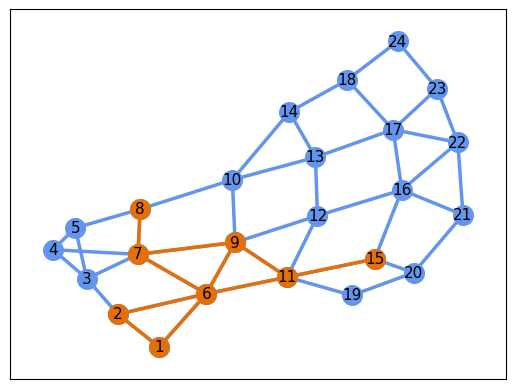

In [30]:
def visao_ISP(pos, topology, ISP_node_list, ISP_edge_list, global_vision=True):

    color = (np.random.rand(), np.random.rand(), np.random.rand())
    blue = (100/255,149/255,237/255)
    
    

    if global_vision:
        nx.draw_networkx_nodes(topology, pos, node_size=200, node_color=blue)    
        nx.draw_networkx_edges(topology, pos, node_size=200, edge_color=blue, width=2.5)
    nx.draw_networkx_nodes(topology, pos, nodelist=ISP_node_list, node_size=200, node_color=color)
    nx.draw_networkx_edges(topology, pos, node_size=200, edgelist=ISP_edge_list, edge_color=color, width=2.5)
    nx.draw_networkx_labels(topology, pos, font_size=11, font_family="sans-serif")

    print(ISP_node_list)

index = 1
gv = True
pos = nx.spring_layout(topology, seed=7)
visao_ISP(pos, topology, ISP_list[index]["nodes"], ISP_list[index]["edges"], global_vision=gv)

In [34]:
def scramble_dict_keys(d):
    # Extract keys and values
    keys = list(d.keys())
    values = list(d.values())

    # Shuffle the keys
    np.random.shuffle(keys)

    # Create a new dictionary with scrambled keys but original values
    scrambled_dict = {keys[i]: values[i] for i in range(len(keys))}
    return scrambled_dict

[21, 16, 20, 22, 15, 19, 15, 19]
[6, 1, 2, 7, 9, 11, 8, 15]
[15, 11, 16, 20, 19, 22, 17, 12]
[10, 8, 9, 13, 14, 5, 7, 17, 18, 5, 7, 12]
[24, 18, 23]


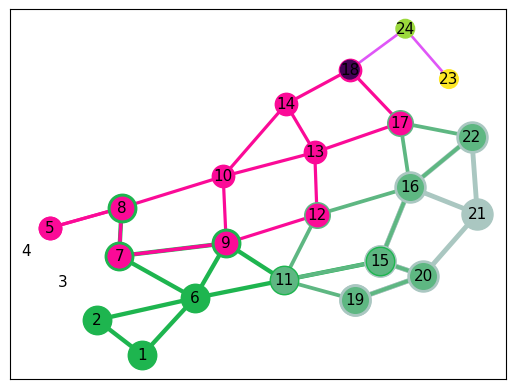

In [56]:
def visao_todas_ISPs(pos, topology, ISP_dict:dict):
    blue = (100/255,149/255,237/255)
    node_size = 500
    node_range = 400

    edge_width = 3.5
    edge_range = 2
    print(ISP_dict)
    #nx.draw_networkx_nodes(topology, pos, node_size=node_size, node_color=blue)
    #nx.draw_networkx_edges(topology, pos, edge_color=blue, width=edge_width)
    ISP_dict = scramble_dict_keys(ISP_dict)
    print(ISP_dict)
    for i, key in enumerate(ISP_dict.keys()):
            
            ISP_node_list = ISP_dict[key]["nodes"]
            ISP_edge_list = ISP_dict[key]["edges"]

            color = (np.random.rand(), np.random.rand(), np.random.rand())
            
            nx.draw_networkx_nodes(topology, pos, nodelist=ISP_node_list, node_size=(node_size-(i*node_range/len(ISP_dict))), node_color=color)
            
            nx.draw_networkx_edges(topology, pos, node_size=200, edgelist=ISP_edge_list, edge_color=color, width=(edge_width-(i*edge_range/len(ISP_dict))))
            print(ISP_node_list)
            
    nx.draw_networkx_labels(topology, pos, font_size=11, font_family="sans-serif")
    

pos = nx.spring_layout(topology, seed=7)
visao_todas_ISPs(pos, topology, ISP_list)

In [10]:

def return_topology_after_simulation(topology):
    env = simpy.Environment()
    rate = NUM_OF_REQUESTS / HOLDING_TIME
    simulador = Simulador(env, topology, 10)
    env.run(until=3600)
    return simulador

simulador = return_topology_after_simulation(topology)

Simulation interrupted at time 1800


In [11]:
df = pd.DataFrame(simulador.req).transpose()

In [12]:
simulador.timeSimFim

1800

In [13]:
df

,num,class,num_slots,path,path_length,spectro,tempo_criacao,tempo_desalocacao,distacia,bandwidth,blocked
1,1,2,32,"[7, 3]",2,"[0, 10]",0.035138,0.216072,1000,400,False
2,2,3,16,"[1, 6, 9, 12, 16, 22, 23]",7,"[0, 15]",0.054689,0.077662,5600,200,False
3,3,2,16,"[8, 10, 13]",3,"[0, 7]",0.274156,0.436534,1850,200,False
4,4,3,28,"[22, 16, 12, 9, 7, 3]",6,"[0, 27]",0.536203,0.592724,4800,350,False
5,5,3,28,"[3, 7, 9, 12, 16, 21, 20]",7,"[28, 55]",0.544586,0.631778,5700,350,False
...,...,...,...,...,...,...,...,...,...,...,...
18077,18077,3,16,"[9, 7, 4, 5]",4,"[0, 15]",1799.410159,1799.538062,2650,200,False
18078,18078,2,12,"[11, 6, 2]",3,"[0, 11]",1799.524742,1799.531868,2850,150,False
18079,18079,1,28,"[21, 16, 12, 9, 6, 2]",6,"[0, 27]",1799.586859,1799.63438,5150,350,False
18080,18080,3,20,"[18, 14, 10, 9]",4,"[0, 19]",1799.88301,1799.939112,3050,250,False


In [14]:
for u, k in list(simulador.topology.edges):
    for slots in simulador.topology[10][13]["capacity"]:
        if slots == 1:
            print( f"({u}, {k})")

In [15]:

TEMPO_DE_ANTECEDENCIA = 10 #minutos
#4 provedores medios, se cumunicam com o provedor de infra instrutura em momentos diferentes
LINK_POINTS = [[6,9,1],[9,11,3],[7,9,6],[9,12,6],[9,10,9],[6,7,9],[11,12,9]]

#pontos de falha = no, tempo [[4,2], [2,5]]
NODE_POINTS = [[9,9]]

DATABASES = [ [4, 23,  30000], [3, 22, 30000], [2, 21, 30000]]


In [16]:
simulador.topology.edges

EdgeView([(1, 2), (1, 6), (2, 3), (2, 6), (6, 7), (6, 9), (6, 11), (3, 7), (3, 4), (3, 5), (7, 4), (7, 9), (7, 8), (4, 5), (5, 8), (8, 10), (9, 10), (9, 11), (9, 12), (11, 19), (11, 15), (11, 12), (10, 13), (10, 14), (12, 13), (12, 16), (13, 14), (13, 17), (14, 18), (19, 20), (15, 16), (15, 20), (16, 22), (16, 21), (16, 17), (17, 18), (17, 23), (17, 22), (18, 24), (20, 21), (22, 21), (22, 23), (23, 24)])

In [17]:
print(simulador.topology[10][13]["capacity"])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
def selecionaCaminhosBruteForce():
    pass

In [19]:
def selecionaCaminho():
    pass

d:\Desktop\Simulador\.venv\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


NameError: name 'k_paths' is not defined

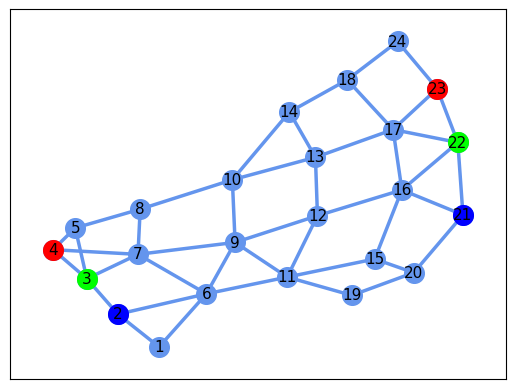

In [20]:
MOMENTODESASTRELINK = 2
MOMENTODESASTRENODE = 1
def pinta_grafo(topology: Graph, momento:int = LINK_POINTS[-1][-1]):
    copiatopo = topology.copy()
    blue = (100/255,149/255,237/255)
    colors = [ (1,0,0), (0,1,0), (0,0,1), (0.5, 0.8, 0.1)]

    links_a_serem_removidos = []
    nodes_a_serem_removidos = []
    
    for link in LINK_POINTS:
        if link[MOMENTODESASTRELINK] > momento:
            break
        links_a_serem_removidos.append(link)

    for node in NODE_POINTS:
        if node[MOMENTODESASTRENODE] > momento:
            break
        nodes_a_serem_removidos.append(node[0])
    pos = nx.spring_layout(copiatopo, seed=7)
    
    #copiatopo.remove_edges_from(links_a_serem_removidos)
    #copiatopo.remove_nodes_from(nodes_a_serem_removidos)
    
    
    nx.draw_networkx_nodes(copiatopo, pos, node_size=200, node_color=blue)

    for i, node in enumerate(DATABASES):
        nx.draw_networkx_nodes(copiatopo, pos,nodelist=node[:2], node_size=200, node_color=colors[i])

    nx.draw_networkx_edges(copiatopo, pos, node_size=200, edge_color=blue, width=2.5)
    nx.draw_networkx_labels(copiatopo, pos, font_size=11, font_family="sans-serif")
    

    paths_available = {}
    for database in DATABASES:
        key = (database[0], database[1])
        paths_available[key] = []
        for path in k_paths[key]:
            validPath = True
            for i in range( 0, len(path)-1):
                if not copiatopo.has_edge(path[i],path[i+1]):
                    validPath = False
                    break
            if (validPath):
                paths_available[key].append(path)
    
    caminhos_finais = {}
    # caminhos_finais = selecionaCaminhos()
    for key, paths in paths_available.items():
        first_path = paths[0]  # Selecting only the first path
        edges = [(first_path[i], first_path[i+1]) for i in range(len(first_path)-1)]
        caminhos_finais[key] = edges


    for i, key in enumerate(caminhos_finais):
        nx.draw_networkx_edges(copiatopo, pos, node_size=200,edgelist=caminhos_finais[key], edge_color=colors[i], width=2.5)


    for (src, dest) in copiatopo.edges:
        soma = 0
        for slot in copiatopo[src][dest]["capacity"]:
            if slot == 0:
                soma += 1
        copiatopo[src][dest]["livre"] = soma
    edge_labels = nx.get_edge_attributes(copiatopo, "livre")
    nx.draw_networkx_edge_labels(copiatopo, pos, edge_labels, font_size=5)
    

    return (copiatopo, caminhos_finais)
    
pinta_grafo(topology, 9)

In [ ]:
k_paths[(4,23)]